# Strongly-coupled thermoelasticity - 2nd Danilovskaya problem

We consider the second Danilovskaya problem, initially introduced in [DANILOVSKAYA, 1952] and solved analytically on a one-dimensional case. This problem has since become a typical benchmark in strongly-coupled thermo-mechanics and has been extensively used in the litterature for implementation validation purposes.

Benchmark from [ARTICLE][1]

[1]: <https://en.wikipedia.org/wiki/Hobbit#Lifestyle> "Hobbit lifestyles"

We start by importing the relevant modules, in particular those related to the NGsolve FE software.

In [1]:
from ngsolve import *
from ngsolve.webgui import Draw
from ngsolve.meshes import MakeStructured3DMesh
import matplotlib.pyplot as plt
import numpy as np
import time as tt

## 1) Problem description

We will solve a transient thermoelastic evolution problem in which both thermo-mechanical fields are fully coupled. However, the evolution is assumed quasi-static and the inertial effects will hence be neglected. We will consider both linear and non-linear thermo-elasticity. The corresponding governing equations will be stated later.

As depicted in the figure below, we consider a bar of $x$-axis with a square cross-section. The bar is clamped at $x=L$, while the $x=0$ section is left free. The displacement along $y$- and $z$-axis are constrained on the lateral faces, as depicted in the figure below. The thermal and mechanical fields evolution is induced by a forced convection condition on the boundary $x=0$. All other faces have zero flux conditions.

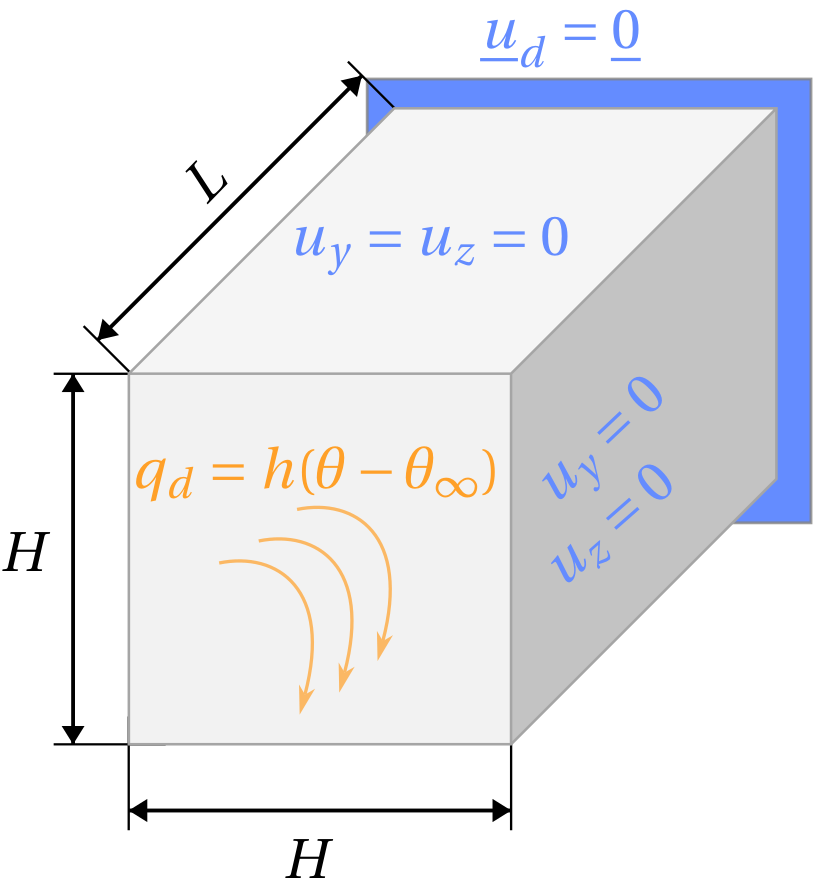


### Space & time domain
The bar is of length $L=6mm$ and height and width $H=4mm$. The geometry is discretized with $12\times 4\times 4$ hexaedral elements. We condider the time interval $[0s, 4s]$, uniformly discretized in $1001$ time steps.

In [2]:
# Geometry
H = 4e-3             # height and thickness (m) 
L = 6e-3             # length (m)

# Time discretization
dt   = 0.004           # time increment (s)     
tmax = 4              # total time (s)

# Mesh (hexaedras)
mesh = MakeStructured3DMesh(hexes=True, nx=12,ny=4,nz=4, 
                            mapping=lambda x,y,z : (6e-3*x,4e-3*y,4e-3*z))
xmin, xmax = "back", "front"        # Name the surfaces to apply BCs
ymin, ymax = "left", "right"
zmin, zmax = "bottom", "top"

Draw(mesh)

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.24…

BaseWebGuiScene

### Material properties

The constitutive material is isotropic and homogeous. The thermo-elastic material properties are taken according to [Shu].

In [3]:
# Material - mechanics
E  = 210e9            # Young modulus (Pa)
nu = 0.3              # Poisson's ratio
mu   = E / 2 / (1+nu) # Lamé parameters
lam  = E * nu / ((1+nu)*(1-2*nu))

# Material - thermics
T0   = 273.15         # reference temperature (K)
Tinf = 100            # ambient temperature (K)
k    = 1.03           # thermal conductivity (W/m/K)
h    = 6.45306        # convection coefficient (W/m2/K)
rho  = 7850           # density (kg/m3)
c    = 0.821          # thermal capacity (J/K/kg)

# Material - coupling
alpha = 1.1e-5        # thermal expansion coefficient (/K)
beta  = alpha*(2*mu+3*lam)

# Setup of elastic quantities
def eps(v):
    return Sym(Grad(v))

def sigmaElastic(strain):
    return 2*mu*strain + lam*Trace(strain)*Id(3)

# Function to display temperature field over time
def display(solution):
    gfu , gft= GridFunction(Hmk), GridFunction(Hth)
    scene = Draw(gft, mesh, deformation = gfu*200)
    i = 0
    for u, th in zip(solution.components[0].vecs, solution.components[1].vecs) :
        gfu.vec.data = u.data
        gft.vec.data = th.data
        print(f"\rt = {time[i]:.3f} s   ", end="")
        scene.Redraw()
        i+=1

## 2) Linear thermo-elasticity

### Function spaces

We now define the relevant functional spaces for the considered problem. Dirichlet boundary conditions are included in these spaces. Since we will adopt a monolithic approach, in which both the displacement $u$ and temperature variation $\theta=T-T_0$ fields are coupled and solved at the same time, we will need to resort to a mixed function space.

In [ ]:
# FE space (Taylor-Hood elements)
order_mk = 2
order_th = 1
Hmk = VectorH1(mesh, order = order_mk,
               dirichletx = xmax,
               dirichlety = xmax+"|"+ymax+"|"+ymin+"|"+zmax+"|"+zmin,
               dirichletz = xmax+"|"+ymax+"|"+ymin+"|"+zmax+"|"+zmin)         # Include (homogeneous) Dirichlet BCs
Hth = H1(mesh, order = order_th)
Hmixed = Hmk*Hth                                                              # Mixed FE space for monolithic resolution
(u,th), (uStar,thStar) = Hmixed.TnT()                                         # Trial and test functions

### Variational formulation

Find $ (u,\theta) \in (H^1(\Omega))^3 \times H^1(\Omega) $, such that

$$ \forall u^* \in (H^1_0(\Omega))^3, \quad \int_\Omega \varepsilon(u) : \boldsymbol{K} : \varepsilon(u^*) - \int_\Omega \beta~\theta ~ \text{Tr}(\varepsilon(u^*))= 0  $$

$$ \forall \theta^* \in H^1_0(\Omega), \quad \int_\Omega \rho c \dot{\theta} \theta^* + \int_\Omega k \nabla \theta \cdot \nabla \theta^* + \int_{\partial_c\Omega} h \theta \theta^* + \int_\Omega \beta T_0 ~\text{tr}(\varepsilon(\dot{u})) \theta^* = \int_{\partial_c\Omega} h \theta_{ext}  \theta^* $$

In [4]:
# Weak form
def StiffnessMatrix(u,theta,uStar,thetaStar):
    K = InnerProduct( eps(uStar), sigmaElastic(eps(u)) )   * dx               # pure elasticity
    K += - beta * theta * Trace(eps(uStar))                * dx               # thermo-elasticity (Th -> M)
    K += k * InnerProduct( grad(theta), grad(thetaStar) )  * dx               # pure thermal (conduction)         
    K += h * theta * thetaStar                             * ds(xmin)         # thermal convection
    return K

def MassMatrix(uDot,thetaDot,uStar,thetaStar,th = 0):                         # th will be useful in the nonlinear case
    M = rho * c * thetaDot * thetaStar                     * dx               # pure thermal (transient)
    #M += beta * (T0 + th) * Trace(eps(uDot)) * thetaStar   * dx               # thermo-elasticity (M-Th)
    return M

def RHS(thetaStar):
    return h * Tinf * thetaStar                        * ds(xmin)             # thermal convection

### Resolution

The linear problem is now solved by looping over time increments. Note that since we work in terms of temperature variation $\theta$ and not absolute temperature $T$, all fields can be initialized to zero. Otherwise $T$ would have needed to be initialized to the reference temperature $T_0$. 

In [5]:
time = np.arange(0,tmax+dt,dt)

def linearSolve(time):
    dt = float(time[1]-time[0])
    tic = tt.time()

    # Initialization
    Uold = GridFunction(Hmixed)             # solution vector at previous time step
    Unew = GridFunction(Hmixed)             # solution vector at new time step
    UL = GridFunction(Hmixed, multidim=0)   # solutio over entire space and time
    ULinear, TLinear = [0], [T0]            # storage of solutions at coordinate point (1,H/2,H/2)

    # Matrices
    K = StiffnessMatrix(u,th,uStar,thStar)
    M = MassMatrix(u,th,uStar,thStar)

    # System assembly (the matrix is constant: it can be factorized only once)
    KK = BilinearForm(Hmixed)
    KK += (M + dt * K)
    KK.Assemble()
    inv = KK.mat.Inverse(freedofs=Hmixed.FreeDofs(), inverse = "pardiso")

    # Loop on time
    for i,t in enumerate(time[1:]):
        print(f"\rComputing... t = {time[i]:.3f}  / {time[-1]} s ", end="")

        # Build right-hand side
        rhs = LinearForm(Hmixed)   
        rhs += dt * RHS(thStar) + MassMatrix(Uold.components[0],Uold.components[1],uStar,thStar)
        rhs.Assemble()

        # Linear system resolution
        Unew.vec.data = inv * rhs.vec
        UL.AddMultiDimComponent(Unew.vec)   # ?? pour stocker le nouveau pas de temps ?
        Uold = Unew

        ULinear.append(-Unew.components[0](mesh(1e-3,H/2,H/2))[0])  # displacement Ux (m) (minus sign to have displacment along +x-axis)
        TLinear.append(Unew.components[1](mesh(1e-3,H/2,H/2))+T0)   # absolute temperature T=teta+T0 (K)
    tCalc = tt.time()-tic
    print(f"\nElapsed time (linear) : {tCalc:.3f} s")
    return UL, ULinear, TLinear, tCalc

UL, ULinear, TLinear, tCalc = linearSolve(time)

Computing... t = 3.960  / 4.0 s 
Elapsed time (linear) : 1.004 s


The displacement field on the whole structure and over the entire time interval is stored in the UL variable and plotted below.

In [1]:
# Display time evolution of 3D solution - LINEAR case
#     (displacement multiplied by 200)
display(UL)

SyntaxError: invalid syntax (1702655564.py, line 1)

In the litterature, the displacement and temperature solutions are usually plotted at the point of coordinates [L/6, H/2, H/2], denoted by M (see figure below).

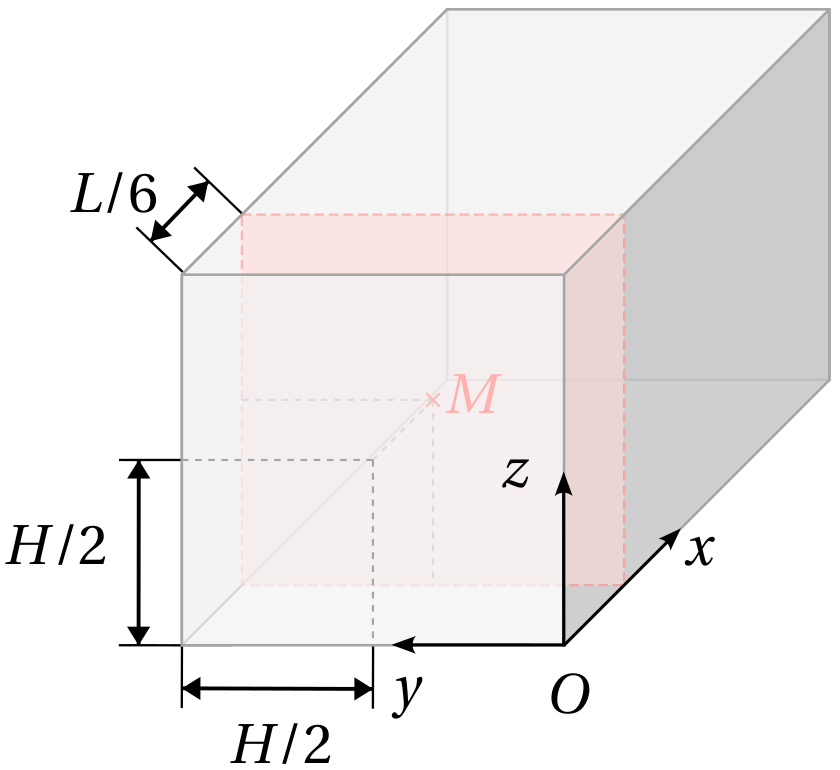

At each time increment, the displacement and temperature solution at point M are saved in the ULinear and TLinear array, respectively.
This evolution is plotted below.

## 3) Non-linear thermo-elasticity

Integral equations :

Find $ (u,\theta) \in (H^1(\Omega))^3 \times H^1(\Omega) $, such that

$$ \forall u^* \in (H^1_0(\Omega))^3, \quad \int_\Omega \varepsilon(u) : K \varepsilon(u^*) - \int_\Omega \beta~\theta ~ \text{tr}(\epsilon(u^*))= 0  $$

$$ \forall \theta^* \in H^1_0(\Omega), \quad \int_\Omega \rho c \dot{\theta} \theta^* + \int_\Omega k \nabla \theta \cdot \nabla \theta^* + \int_\Gamma h \theta \theta^* + \int_\Omega \beta (T_0 \color{red}{+ \theta}) ~\text{tr}(\varepsilon(\dot{u})) \theta^* = \int_\Gamma h (T_{ext} - T_0) \theta^* $$

### Explicit solver

The non-linear problem is solved using an explicit solver:

$$ M(\theta) \dot{U} + K U = F $$
$$ \Rightarrow M(U_{n-1}) \frac{U_n - U_{n-1}}{\delta t} + K U_{n} = F $$
$$ \Rightarrow (M(U_{n-1})+K \delta t) U_n = F ~\delta t  +  M(U_{n-1}) U_{n-1}$$

The problem stays linear, but the mass matrix is updated at each iteration.

In [10]:
def NLSolve(time):
    dt = float(time[1]-time[0])
    tic = tt.time()
    
    # Initialization
    Uold = GridFunction(Hmixed)
    Unew = GridFunction(Hmixed)
    UNLexpl = GridFunction(Hmixed, multidim=0)
    UNonLinearExplicit, TNonLinearExplicit = [0], [T0]

    # Loop on time
    for i,t in enumerate(time[1:]):
        print(f"\rComputing... t = {time[i]:.3f}  / {time[-1]} s ", end="")

        # Matrices
        KK = BilinearForm(Hmixed)
        KK += dt * StiffnessMatrix(u,th,uStar,thStar) + MassMatrix(u,th,uStar,thStar,Uold.components[1])
        M = BilinearForm(Hmixed)
        M += MassMatrix(u,th,uStar,thStar,Uold.components[1])
        Fdt = LinearForm(Hmixed)   
        Fdt += dt * RHS(thStar)

        KK.Assemble()
        M.Assemble()
        Fdt.Assemble()

        Minv = KK.mat.Inverse(freedofs=Hmixed.FreeDofs(), inverse = "pardiso")

        # Resolution
        Unew.vec.data = Minv * (Fdt.vec + M.mat * Uold.vec.data )
        UNLexpl.AddMultiDimComponent(Unew.vec)
        Uold = Unew

        UNonLinearExplicit.append(-Unew.components[0](mesh(1e-3,H/2,H/2))[0])   # displacement Ux (m) (minus sign to have displacment along +x-axis)
        TNonLinearExplicit.append(Unew.components[1](mesh(1e-3,H/2,H/2))+T0)    # absolute temperature T=teta+T0 (K)
    tCalc = tt.time()-tic
    print(f"\nElapsed time (non-linear, explicit) : {tCalc:.3f} s")
    return UNLexpl, UNonLinearExplicit, TNonLinearExplicit, tCalc

UNLexpl, UNonLinearExplicit, TNonLinearExplicit, tCalc = NLSolve(time)

Computing... t = 3.960  / 4.0 s 
Elapsed time (non-linear, explicit) : 28.021 s


In [11]:
# Display time evolution of 3D solution - NONLINEAR case
display(UNLexpl)

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.23…

t = 3.960 s   

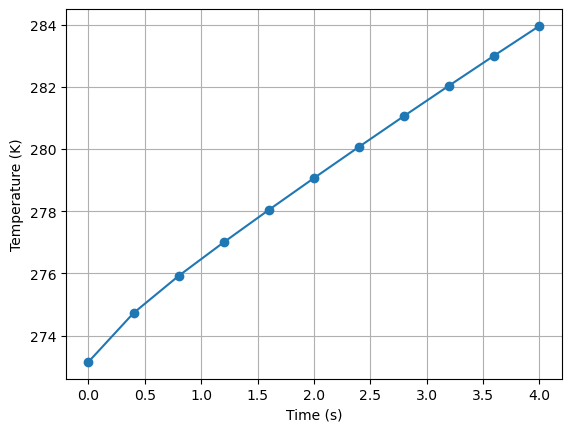

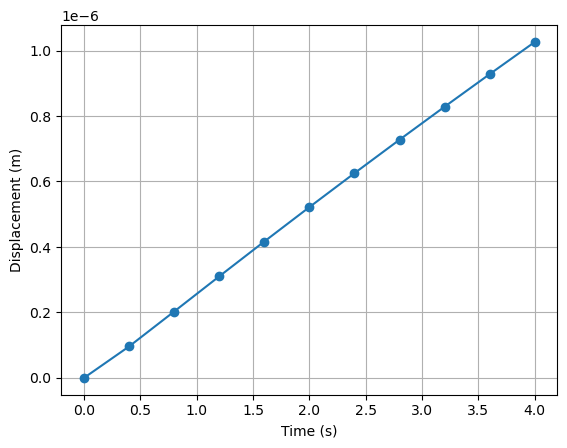

In [10]:
# Plot time evolution at coordinate point (1,H/2,H/2) to compare with litterature
plt.plot(time, TNonLinearExplicit, "-o")
plt.xlabel("Time (s)")
plt.ylabel("Temperature (K)")
plt.grid()
plt.show()

plt.plot(time, UNonLinearExplicit, "-o")
plt.xlabel("Time (s)")
plt.ylabel("Displacement (m)")
plt.grid()
plt.show()

## Analysis of the results
### Convergence of non-linear scheme

In [11]:
# Linear & nonlinear resolutions for increasing number of time steps
N = np.logspace(1,3,5)

listUL = []
listUNL = []

UNLbench = []
ULbench = []
TNLbench = []
TLbench = []

timeL = []
timeNL = []

for n in N:
    time = np.linspace(0,4,int(n))
    UNLexpl, UNonLinearExplicit, TNonLinearExplicit, tNL = NLSolve(time)
    UL, ULinear, TLinear, tL = linearSolve(time)
    
    listUL.append(UL)
    listUNL.append(UNLexpl)
    
    UNLbench.append(UNonLinearExplicit)
    TNLbench.append(TNonLinearExplicit)
    
    ULbench.append(ULinear)
    TLbench.append(TLinear)
    
    timeL.append(tNL)
    timeL.append(tL)    

Computing... t = 3.556  / 4.0 s 
Elapsed time (non-linear, explicit) : 0.728 s
Computing... t = 3.556  / 4.0 s 
Elapsed time (linear) : 0.077 s
Computing... t = 3.867  / 4.0 s 
Elapsed time (non-linear, explicit) : 2.463 s
Computing... t = 3.867  / 4.0 s 
Elapsed time (linear) : 0.168 s
Computing... t = 3.960  / 4.0 s 
Elapsed time (non-linear, explicit) : 8.324 s
Computing... t = 3.960  / 4.0 s 
Elapsed time (linear) : 0.311 s
Computing... t = 3.987  / 4.0 s 
Elapsed time (non-linear, explicit) : 38.633 s
Computing... t = 3.987  / 4.0 s 
Elapsed time (linear) : 1.047 s
Computing... t = 3.996  / 4.0 s 
Elapsed time (non-linear, explicit) : 115.429 s
Computing... t = 3.996  / 4.0 s 
Elapsed time (linear) : 3.474 s


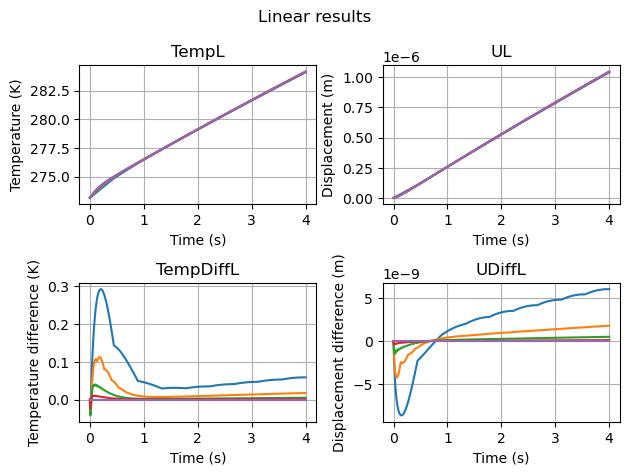

In [12]:
Tfine = np.linspace(0,4,int(N[-1]))  # finest time discretization

for i in range(len(N)):
    T = np.linspace(0,4,int(N[i]))
    plt.subplot(2,2,1)
    plt.plot(T,TLbench[i])
    plt.grid()
    plt.title("TempL")
    plt.ylabel("Temperature (K)")
    plt.xlabel("Time (s)")
    plt.subplot(2,2,2)
    plt.plot(T,ULbench[i])
=    plt.grid()
    plt.title("UL")
    plt.ylabel("Displacement (m)")
    plt.xlabel("Time (s)")
    
    plt.subplot(2,2,3)
    coarseT = np.interp(Tfine, T, TLbench[i])
    plt.plot(Tfine,TLbench[-1]-coarseT)
    plt.grid()
    plt.ylabel("Temperature difference (K)")
    plt.title("TempDiffL")
    plt.xlabel("Time (s)")
    plt.subplot(2,2,4)
    coarseU = np.interp(Tfine, T, ULbench[i])
    plt.plot(Tfine,ULbench[-1]-coarseU)
    plt.title("UDiffL")
    plt.grid()
    plt.ylabel("Displacement difference (m)")
    plt.xlabel("Time (s)")
    
plt.suptitle('Linear results', fontsize=12)
plt.tight_layout()
plt.show()

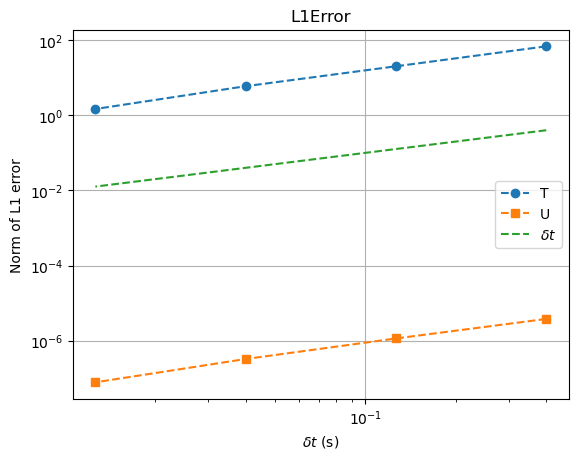

In [59]:
errorU = []
errorT = []

for i in range(len(N)):
    T = np.linspace(0,4,int(N[i]))
    coarseT = np.interp(Tfine, T, TLbench[i])
    coarseU = np.interp(Tfine, T, ULbench[i])
    
    errorU.append(np.sum(np.abs(coarseU - ULbench[-1])))
    errorT.append(np.sum(np.abs(coarseT - TLbench[-1])))

plt.loglog(4/N[:-1],errorT[:-1],'--o',label = "T")
plt.loglog(4/N[:-1],errorU[:-1],'--s',label = "U")
plt.loglog(4/N[:-1],4/N[:-1],'--',label = "$\Delta  t$")
plt.legend()
plt.xlabel("$\Delta t$ (s)")
plt.ylabel("Norm of L1 error")
plt.grid()
plt.title("L1Error")
plt.show()

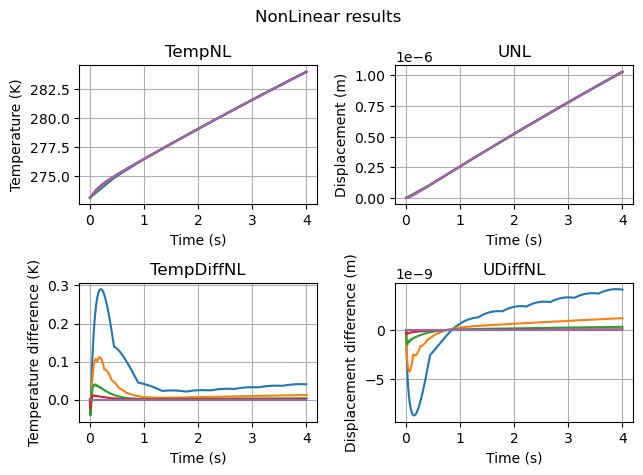

In [52]:
Tfine = np.linspace(0,4,int(N[-1]))

errorU = []
errorT = []

for i in range(len(N)):
    T = np.linspace(0,4,int(N[i]))
    plt.subplot(2,2,1)
    plt.plot(T,TNLbench[i])
    plt.grid()
    plt.title("TempNL") 
    plt.ylabel("Temperature (K)")
    plt.xlabel("Time (s)")
    plt.subplot(2,2,2)
    plt.plot(T,UNLbench[i])
    plt.grid()
    plt.ylabel("Displacement (m)")
    plt.xlabel("Time (s)")
    plt.title("UNL") 
    plt.subplot(2,2,3)
    coarseT = np.interp(Tfine, T, TNLbench[i])
    plt.plot(Tfine,TNLbench[-1]-coarseT)
    plt.title("TempDiffNL") 
    plt.grid()
    plt.ylabel("Temperature difference (K)")
    plt.xlabel("Time (s)")
    plt.subplot(2,2,4)
    coarseU = np.interp(Tfine, T, UNLbench[i])
    plt.plot(Tfine,UNLbench[-1]-coarseU)
    plt.grid()
    plt.ylabel("Displacement difference (m)")
    plt.title("UDiffNL")    
    plt.xlabel("Time (s)")
plt.suptitle('NonLinear results', fontsize=12)
plt.tight_layout()
plt.show()

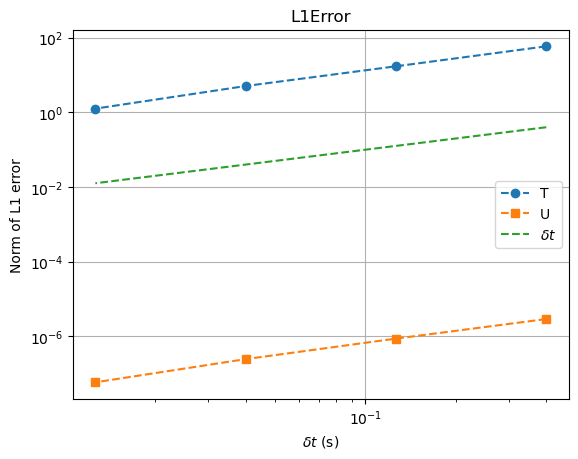

In [66]:
errorU = []
errorT = []

for i in range(len(N)):
    T = np.linspace(0,4,int(N[i]))
    coarseT = np.interp(Tfine, T, TNLbench[i])
    coarseU = np.interp(Tfine, T, UNLbench[i])
    
    errorU.append(np.sum(np.abs(coarseU - UNLbench[-1])))
    errorT.append(np.sum(np.abs(coarseT - TNLbench[-1])))

plt.loglog(4/N[:-1],errorT[:-1],'--o',label = "T")
plt.loglog(4/N[:-1],errorU[:-1],'--s',label = "U")
plt.loglog(4/N[:-1],4/N[:-1],'--',label = "$\delta t$")
plt.legend()
plt.xlabel("$\delta t$ (s)")
plt.ylabel("Norm of L1 error")
plt.grid()
plt.title("L1Error")
plt.show()

### Linear VS nonlinear results

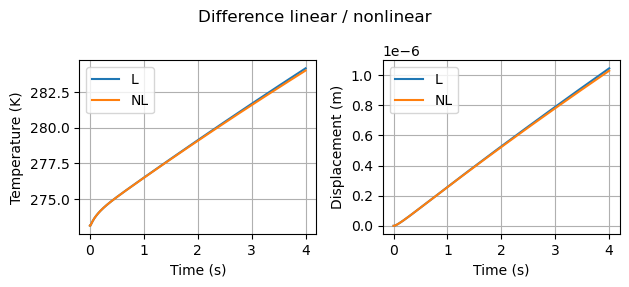

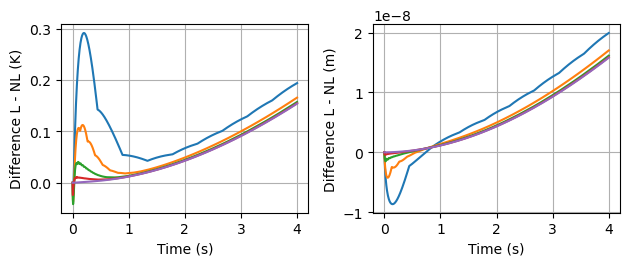

In [71]:
plt.suptitle("Difference linear / nonlinear")
plt.subplot(2,2,1)
plt.plot(Tfine, TLbench[-1], label = "L")
plt.plot(Tfine, TNLbench[-1], label = "NL")

plt.xlabel("Time (s)")
plt.ylabel("Temperature (K)")
plt.grid()
plt.legend()

plt.subplot(2,2,2)
plt.plot(Tfine, ULbench[-1], label = "L")
plt.plot(Tfine, UNLbench[-1], label = "NL")

plt.grid()
plt.xlabel("Time (s)")
plt.ylabel("Displacement (m)")
plt.legend()
plt.tight_layout()
plt.show()

plt.subplot(2,2,3)
plt.xlabel("Time (s)")
plt.ylabel("Difference temp. L - NL (K)")
plt.grid()
plt.subplot(2,2,4)
plt.grid()
plt.xlabel("Time (s)")
plt.ylabel("Difference disp. L - NL (m)")
for i in range(len(N)):
    T = np.linspace(0,4,int(N[i]))
    coarseTNL = np.interp(Tfine, T, TNLbench[i])
    coarseUNL = np.interp(Tfine, T, UNLbench[i])
    plt.subplot(2,2,3)
    plt.plot(Tfine, np.array(TLbench[-1]) - coarseTNL)
    plt.subplot(2,2,4)
    plt.plot(Tfine, np.array(ULbench[-1]) - coarseUNL)
    
plt.tight_layout()
plt.show()
